In [32]:
%matplotlib inline

import importlib
import sys
sys.path.insert(0, '../util')
import utils; importlib.reload(utils)
from utils import *
from vgg16_avg import VGG16_Avg
from scipy.optimize import fmin_l_bfgs_b
from scipy.ndimage.filters import gaussian_filter

In [2]:
# Tell Tensorflow to use no more GPU RAM than necessary
utils.limit_mem()

Data can be downloaded from here. Update path below to where you download data to. Optionally use a 2nd path for fast (e.g. SSD) storage - set both to the same path if using AWS.

In [3]:
path = './imagenet/sample/'
dpath = './imagenet/sample/'

In [4]:
fnames = glob.glob(path + '*/*.JPEG', recursive=True)
n = len(fnames); n

19439

In [5]:
fn = fnames[50]; fn

'./imagenet/sample/n01443537/n01443537_7798.JPEG'

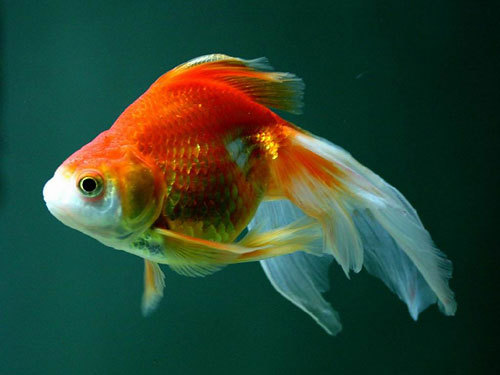

In [6]:
img = Image.open(fn); img

In [7]:
# convert our sample image in a 4D array with dim 0 as image count
img_arr = np.expand_dims(np.array(img), 0)
img_arr.shape

# img = img[::-1]; img

(1, 375, 500, 3)

We'll be using this image with VGG16. Therefore, we need to subtract the mean of each channel of the imagenet data and reverse the order of RGB->BGR since those are the preprocessing steps that the VGG authors did - so their model won't work unless we do the same thing.
We can do this in one step using broadcasting

In [8]:
# imagenet mean for RGB images
imagenet_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
# convert RGB to BGR
bgr_img_arr = img_arr[:,:,:,::-1]

preproc = lambda x: (x-imagenet_mean)[:,:,:,::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + imagenet_mean, 0, 255)


In [9]:
img_arr_vgg = preproc(img_arr)
shp = img_arr_vgg.shape; shp

(1, 375, 500, 3)

Recreate input
The first step in style transfer is understanding how to recreate an image from noise based on "content loss", which is the amount of difference between activations in some layer. In earlier layes, content loss is very similar to per-pixel loss, but in later layers it is capturing the "meaning" of a part of an image, rather than the specific details.
To do this, we first take a CNN and pass an image through it. We then pass a "noise image" (i.e. random pixel values) through the same CNN. At some layer, we compare the outputs from it for both images. We then use a MSE to compare the activations of these two outputs.
The interesting part is that now, instead of updating the parameters of the CNN, we update the pixels of the noisy image. In other words, our goal is to alter the noisy image so as to minimize the difference between the original image's output at some convolutional layer with the output of the noisy image at the same layer.
In order to construct this architecture, we're going to be working with keras.backend, which is an abstraction layer that allows us to target both theano and tensorflow with the same code.
The CNN we'll use is VGG16, but with a twist. Previously we've always used Vgg with max pooling, and this was useful for image classification. It's not as useful in this case however, because max pooling loses information about the original input area. Instead we will use average pooling, as this does not throw away as much information.

In [10]:
model = VGG16_Avg(include_top=False)

In [11]:
# Here we're grabbing the activations from near the end of the convolutional model).
# layer = model.get_layer('block4_conv1').output; layer.shape
layer = model.get_layer('block2_conv2').output; layer.shape


TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(128)])

In [12]:
# And let's calculate the target activations for this layer:
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr_vgg)); targ.shape
# targ = targ.flatten().astype(np.float64); targ.shape

TensorShape([Dimension(1), Dimension(187), Dimension(250), Dimension(128)])

In [13]:
# we need to define an object that will allow us to separately access the loss function and gradients of a function, 
# since that is what scikit-learn's optimizers require.
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
#         op = self.f([x.reshape(self.shp)])
#         loss_, self.grad_values = op[0], op[1]
        print('Loss: ' + str(loss_.astype(np.float64)))
#         print('grad_values:' + self.grad_values)        
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [14]:
loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

In [15]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'./results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

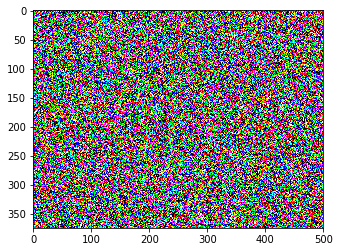

In [16]:
# generate a random image.
# Note that we init starting image to low pixel values to keep background suppressed.

rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
# rand_img = lambda shape: np.random.uniform(-125, 125, shape)
x = rand_img(shp)
# plt.imshow(deproc(x.copy(), shp)[0]);
plt.imshow(x.copy()[0]);

In [34]:
iterations=10
x = solve_image(evaluator, iterations, x)

Loss: 78805.859375
Loss: 78788.3984375
Loss: 78707.3046875
Loss: 78391.359375
Loss: 77531.1875
Loss: 74362.1171875
Loss: 68913.515625
Loss: 42012.9023438
Loss: 36447.0351562
Loss: 32532.0527344
Loss: 29540.2011719
Loss: 26775.6503906
Loss: 24501.4121094
Loss: 22716.5
Loss: 21077.8925781
Loss: 19650.4042969
Loss: 18378.3496094
Loss: 17152.4921875
Loss: 16033.7675781
Loss: 14924.9345703
Loss: 13787.8789062
Current loss value: 13787.8789062
Loss: 13879.8378906
Loss: 13877.9697266
Loss: 13870.5888672
Loss: 13841.4628906
Loss: 13730.1289062
Loss: 13376.1474609
Loss: 12640.4746094
Loss: 12170.6132812
Loss: 11651.2880859
Loss: 10964.9970703
Loss: 10366.0097656
Loss: 9689.36425781
Loss: 8825.36425781
Loss: 8189.25927734
Loss: 7527.50976562
Loss: 6773.82568359
Loss: 6298.62011719
Loss: 5850.50683594
Loss: 5355.83105469
Loss: 5079.56005859
Loss: 4840.609375
Current loss value: 4840.609375
Loss: 5261.15380859
Loss: 5259.74902344
Loss: 5254.14453125
Loss: 5232.27636719
Loss: 5151.74560547
Loss: 47

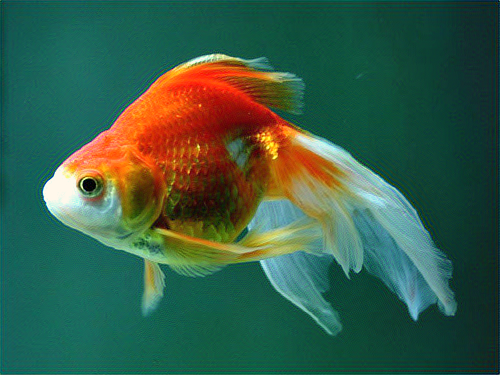

In [35]:
Image.open('./results/res_at_iteration_9.png')

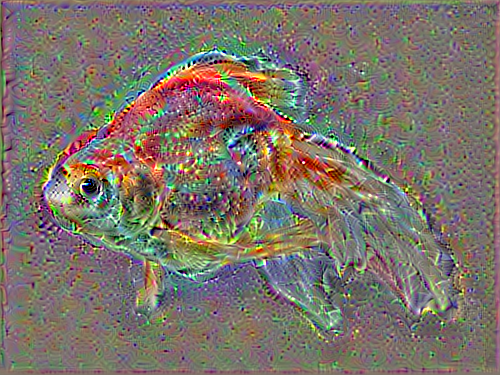

In [25]:
Image.open('./results/res_at_iteration_9.png')

In [17]:
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation, rc

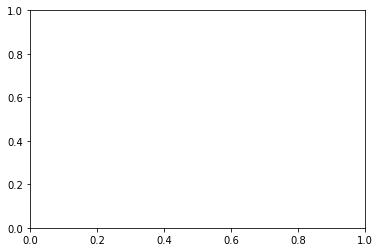

In [18]:
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(f'./results/res_at_iteration_{i}.png'))

In [19]:
anim = animation.FuncAnimation(fig, animate, frames=10, interval=1000)
HTML(anim.to_html5_video())

In [20]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

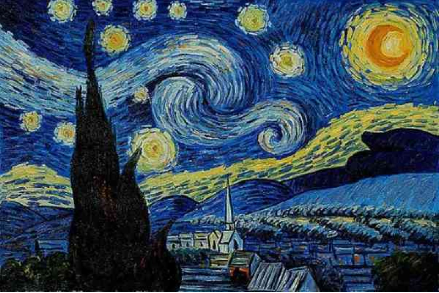

In [21]:
style = Image.open('./data/starry_night.jpg')
style = style.resize(np.divide(style.size,3.5).astype('int32')); style

In [22]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3]);
shp = style_arr.shape; shp

(1, 293, 439, 3)

In [23]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

In [24]:
outputs

{'block1_conv1': <tf.Tensor 'Relu_13:0' shape=(?, 293, 439, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'Relu_14:0' shape=(?, 293, 439, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'AvgPool_5:0' shape=(?, 146, 219, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'Relu_15:0' shape=(?, 146, 219, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'Relu_16:0' shape=(?, 146, 219, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'AvgPool_6:0' shape=(?, 73, 109, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'Relu_17:0' shape=(?, 73, 109, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'Relu_18:0' shape=(?, 73, 109, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'Relu_19:0' shape=(?, 73, 109, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'AvgPool_7:0' shape=(?, 36, 54, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'Relu_20:0' shape=(?, 36, 54, 512) dtype=float32>,
 'block4_conv2': <tf.Tensor 'Relu_21:0' shape=(?, 36, 54, 512) dtype=float32>,
 'block4_conv3': <tf.Tensor 'Relu_22:0

In [29]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]; layers

[<tf.Tensor 'Relu_13:0' shape=(?, 293, 439, 64) dtype=float32>,
 <tf.Tensor 'Relu_15:0' shape=(?, 146, 219, 128) dtype=float32>]

In [37]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

In [38]:
targs

[<tf.Variable 'Variable_5:0' shape=(1, 293, 439, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_6:0' shape=(1, 146, 219, 128) dtype=float32_ref>]

In [39]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))


In [40]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

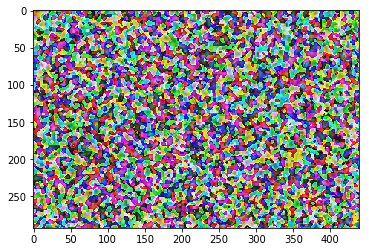

In [41]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = gaussian_filter(x, [0,2,2,0])
plt.imshow(x[0]);

In [42]:
iterations=10
x = rand_img(shp)

In [43]:
x = solve_image(evaluator, iterations, x)

Loss: 136712.25
Loss: 136711.703125
Loss: 136709.671875
Loss: 136701.4375
Loss: 136665.328125
Loss: 136477.8125
Loss: 135059.1875
Loss: 119401.28125
Loss: 56421.6679688
Loss: 74685.671875
Loss: 43094.4296875
Loss: 2385086.0
Loss: 43048.6328125
Loss: 38047.796875
Loss: 29432.7871094
Loss: 22635.6699219
Loss: 20729.5429688
Loss: 25311.5253906
Loss: 16332.4375
Loss: 13883.2607422
Loss: 8796.65429688
Current loss value: 8796.65429688
Loss: 8584.41601562
Loss: 8582.94335938
Loss: 8577.07128906
Loss: 8553.80371094
Loss: 8464.03320312
Loss: 8156.60205078
Loss: 7050.11523438
Loss: 5657.85839844
Loss: 3596.8605957
Loss: 3198.78393555
Loss: 2985.85546875
Loss: 2419.76635742
Loss: 2040.18383789
Loss: 1458.14306641
Loss: 1006.16741943
Loss: 1131.94689941
Loss: 910.870117188
Loss: 733.871582031
Loss: 592.268981934
Loss: 474.136779785
Loss: 538.081787109
Loss: 442.590209961
Current loss value: 442.590209961
Loss: 476.663269043
Loss: 476.352752686
Loss: 475.123199463
Loss: 470.424346924
Loss: 455.159

### Style transfer

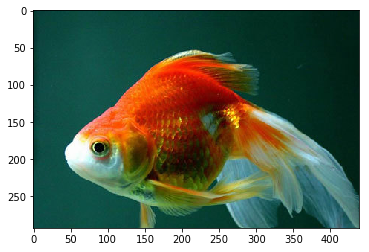

In [45]:
# We now know how to reconstruct an image, as well as how to construct an image that captures the style 
# of an original image. The obvious idea may be to just combine these two approaches by weighting and adding 
# the two loss functions.

w,h = style.size
src = img_arr_vgg[:,:h,:w]
plot_arr(src)

In [46]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [47]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [48]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

Now to actually merge the two approaches is as simple as merging their respective loss functions. Note that as opposed to our previous to functions, this function is producing three separate types of outputs: one for the original image, one for the image whose style we're emulating, and one for the random image whose pixel's we are training. 

One way for us to tune how the reconstructions mix is by changing the factor on the content loss, which we have here as 1/10. If we increase that denominator, the style will have a larger effect on the image, and if it's too large the original content of the image will be obscured by unstructured style. Likewise, if it is too small than the image will not have enough style.

In [49]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [50]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += metrics.mse(content_layer, content_targ)/10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [51]:
evaluator = Evaluator(transfer_fn, shp)

In [52]:
iterations=10
x = rand_img(shp)

In [53]:
x = solve_image(evaluator, iterations, x)

Loss: 107382.679688
Loss: 107382.15625
Loss: 107379.984375
Loss: 107371.273438
Loss: 107333.195312
Loss: 107136.625
Loss: 105631.0
Loss: 89471.2109375
Loss: 229425.90625
Loss: 61180.84375
Loss: 57339.8242188
Loss: 57282.5859375
Loss: 1751746.625
Loss: 57243.3671875
Loss: 53810.7890625
Loss: 44170.2734375
Loss: 35178.9023438
Loss: 23064.3828125
Loss: 22039.921875
Loss: 18280.9648438
Loss: 19321.6503906
Loss: 11468.9179688
Current loss value: 11468.9179688
Loss: 11068.0683594
Loss: 11065.78125
Loss: 11056.6220703
Loss: 11020.3017578
Loss: 10879.40625
Loss: 10384.4257812
Loss: 8575.07617188
Loss: 7186.20263672
Loss: 6452.22558594
Loss: 5811.07519531
Loss: 5623.59277344
Loss: 5253.82080078
Loss: 4826.77392578
Loss: 4534.01416016
Loss: 3954.20019531
Loss: 3450.71948242
Loss: 2984.88671875
Loss: 2413.54589844
Loss: 2615.72973633
Loss: 2218.83032227
Loss: 1984.53759766
Current loss value: 1984.53759766
Loss: 2031.40112305
Loss: 2030.86230469
Loss: 2028.72192383
Loss: 2020.31787109
Loss: 1989.

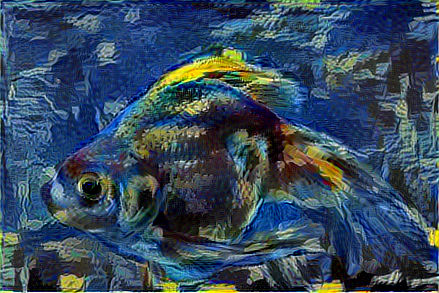

In [55]:
Image.open('./results/res_at_iteration_9.png')